In [ ]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from keras.applications.inception_v3 import InceptionV3, preprocess_input
from scipy.linalg import sqrtm
from PIL import Image

#### Melakukan read dataset yang akan digunakan.

In [2]:
def load_images_from_folder(folder_path, target_size=(100, 100)):
    image_arrays = []
    for filename in os.listdir(folder_path):
        img_path = os.path.join(folder_path, filename)
        img = Image.open(img_path).convert('RGB')
        img = img.resize(target_size)
        img_array = np.asarray(img) / 255.0 
        image_arrays.append(img_array)
    return np.array(image_arrays)

image_files = load_images_from_folder('A_23')
print(f"Dataset Shape: {image_files.shape}")


Dataset Shape: (1074, 100, 100, 3)


#### Dikarenakan kali ini saya akan menerapkan GAN, maka saya tidak akan melakukan splitting data, hal tersebut dikarenakan splitting tidak cocok digunakan dalam pemodelan GAN. Maka dari itu akan langsung masuk ke bagian modelling.

In [ ]:
random_input = layers.Input(shape=50)

x = layers.Dense(106 * 106 * 16, activation='relu')(random_input)
x = layers.Reshape((106, 106, 16))(x)

x = layers.Conv2D(16, kernel_size=(3, 3), strides=1, padding='valid', activation='relu')(x)

x = layers.Conv2D(32, kernel_size=(3, 3), strides=1, padding='valid', activation='relu')(x)

x = layers.Conv2D(64, kernel_size=(3, 3), strides=1, padding='valid', activation='relu')(x)

output_image = layers.Conv2D(3, kernel_size=(1, 1), activation='tanh')(x)

generator_model = models.Model(inputs=random_input, outputs=output_image)
generator_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 50)]              0         
                                                                 
 dense (Dense)               (None, 179776)            9168576   
                                                                 
 reshape (Reshape)           (None, 106, 106, 16)      0         
                                                                 
 conv2d (Conv2D)             (None, 104, 104, 16)      2320      
                                                                 
 conv2d_1 (Conv2D)           (None, 102, 102, 32)      4640      
                                                                 
 conv2d_2 (Conv2D)           (None, 100, 100, 64)      18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 100, 100, 3)       195   

In [4]:
image_input = layers.Input(shape=(100, 100, 3))

x = layers.Conv2D(16, kernel_size=(3, 3), strides=1, padding='valid', activation='relu')(image_input)

x = layers.Conv2D(32, kernel_size=(3, 3), strides=1, padding='valid', activation='relu')(x)

x = layers.Conv2D(64, kernel_size=(3, 3), strides=1, padding='valid', activation='relu')(x)

x = layers.Flatten()(x)
output = layers.Dense(1, activation='sigmoid')(x)

discriminator_model = models.Model(inputs=image_input, outputs=output)
discriminator_model.summary()


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 100, 100, 3)]     0         
                                                                 
 conv2d_4 (Conv2D)           (None, 98, 98, 16)        448       
                                                                 
 conv2d_5 (Conv2D)           (None, 96, 96, 32)        4640      
                                                                 
 conv2d_6 (Conv2D)           (None, 94, 94, 64)        18496     
                                                                 
 flatten (Flatten)           (None, 565504)            0         
                                                                 
 dense_1 (Dense)             (None, 1)                 565505    
                                                                 
Total params: 589,089
Trainable params: 589,089
Non-trainab

In [5]:
discriminator_model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.01), metrics=['accuracy'])
generator_model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.01), metrics=['accuracy'])

In [6]:
discriminator_model.trainable=False

g_output = generator_model(random_input)
d_output = discriminator_model(g_output)

gan_model = models.Model(random_input, d_output)
gan_model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 50)]              0         
                                                                 
 model (Functional)          (None, 100, 100, 3)       9194227   
                                                                 
 model_1 (Functional)        (None, 1)                 589089    
                                                                 
Total params: 9,783,316
Trainable params: 9,194,227
Non-trainable params: 589,089
_________________________________________________________________


In [7]:
gan_model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.001))

#### Selanjutnya saya akan membuat function untuk melakukan train menggunakan model gan yang telah dibuat tadi.

In [9]:
def train_gan(image_files, generator_model, discriminator_model, gan_model, epochs=1000, batch_size=64, print_interval=500):
    valid_labels = np.ones((batch_size, 1))
    fake_labels  = np.zeros((batch_size, 1)) 

    for epoch in range(1, epochs + 1):
        idx = np.random.randint(0, image_files.shape[0], batch_size)
        real_imgs = image_files[idx]
        
        noise = np.random.uniform(-1, 1, size=(batch_size, 50))
        fake_imgs = generator_model.predict(noise, verbose=2)

        d_loss_real = discriminator_model.train_on_batch(real_imgs, valid_labels) 
        d_loss_fake = discriminator_model.train_on_batch(fake_imgs, fake_labels)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        g_loss  = gan_model.train_on_batch(noise, valid_labels)

        if epoch % print_interval == 0:
            d_loss_value = d_loss[0] if isinstance(d_loss, np.ndarray) else d_loss
            g_loss_value = g_loss[0] if isinstance(g_loss, np.ndarray) else g_loss

            print(f"Epoch {epoch}  D-loss: {d_loss_value:.4f},  G-loss: {g_loss_value:.4f}")
            
            sample_noise = np.random.uniform(-1,1,(5, 50))
            gen_imgs      = generator_model.predict(sample_noise, verbose=0)

            gen_imgs = 0.5 * gen_imgs + 0.5
            sample_noise = np.random.uniform(-1, 1, (5, 50))
            fig, axes = plt.subplots(1, 5, figsize=(10,2))
            for i, ax in enumerate(axes):
                ax.imshow(gen_imgs[i])
                ax.axis('off')
            plt.suptitle(f"Epoch {epoch}")
            plt.show()


#### Melakukan training untuk model GAN yang telah dibuat.

2/2 - 5s - 5s/epoch - 2s/step
2/2 - 0s - 37ms/epoch - 19ms/step
2/2 - 0s - 32ms/epoch - 16ms/step
2/2 - 0s - 36ms/epoch - 18ms/step
2/2 - 0s - 31ms/epoch - 15ms/step
2/2 - 0s - 36ms/epoch - 18ms/step
2/2 - 0s - 34ms/epoch - 17ms/step
2/2 - 0s - 35ms/epoch - 18ms/step
2/2 - 0s - 30ms/epoch - 15ms/step
2/2 - 0s - 29ms/epoch - 15ms/step
2/2 - 0s - 31ms/epoch - 15ms/step
2/2 - 0s - 31ms/epoch - 15ms/step
2/2 - 0s - 34ms/epoch - 17ms/step
2/2 - 0s - 29ms/epoch - 15ms/step
2/2 - 0s - 33ms/epoch - 16ms/step
2/2 - 0s - 30ms/epoch - 15ms/step
2/2 - 0s - 39ms/epoch - 20ms/step
2/2 - 0s - 30ms/epoch - 15ms/step
2/2 - 0s - 34ms/epoch - 17ms/step
2/2 - 0s - 35ms/epoch - 17ms/step
2/2 - 0s - 54ms/epoch - 27ms/step
2/2 - 0s - 32ms/epoch - 16ms/step
2/2 - 0s - 30ms/epoch - 15ms/step
2/2 - 0s - 31ms/epoch - 15ms/step
2/2 - 0s - 32ms/epoch - 16ms/step
2/2 - 0s - 30ms/epoch - 15ms/step
2/2 - 0s - 31ms/epoch - 15ms/step
2/2 - 0s - 32ms/epoch - 16ms/step
2/2 - 0s - 31ms/epoch - 15ms/step
2/2 - 0s - 35ms/ep

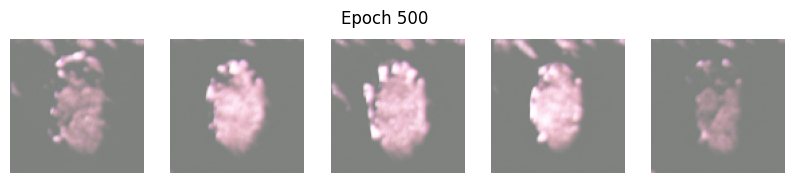

2/2 - 0s - 40ms/epoch - 20ms/step
2/2 - 0s - 35ms/epoch - 18ms/step
2/2 - 0s - 29ms/epoch - 15ms/step
2/2 - 0s - 33ms/epoch - 16ms/step
2/2 - 0s - 29ms/epoch - 15ms/step
2/2 - 0s - 28ms/epoch - 14ms/step
2/2 - 0s - 32ms/epoch - 16ms/step
2/2 - 0s - 32ms/epoch - 16ms/step
2/2 - 0s - 32ms/epoch - 16ms/step
2/2 - 0s - 31ms/epoch - 16ms/step
2/2 - 0s - 32ms/epoch - 16ms/step
2/2 - 0s - 33ms/epoch - 16ms/step
2/2 - 0s - 32ms/epoch - 16ms/step
2/2 - 0s - 31ms/epoch - 15ms/step
2/2 - 0s - 30ms/epoch - 15ms/step
2/2 - 0s - 37ms/epoch - 18ms/step
2/2 - 0s - 31ms/epoch - 16ms/step
2/2 - 0s - 34ms/epoch - 17ms/step
2/2 - 0s - 30ms/epoch - 15ms/step
2/2 - 0s - 35ms/epoch - 18ms/step
2/2 - 0s - 31ms/epoch - 16ms/step
2/2 - 0s - 31ms/epoch - 15ms/step
2/2 - 0s - 30ms/epoch - 15ms/step
2/2 - 0s - 30ms/epoch - 15ms/step
2/2 - 0s - 32ms/epoch - 16ms/step
2/2 - 0s - 33ms/epoch - 16ms/step
2/2 - 0s - 32ms/epoch - 16ms/step
2/2 - 0s - 32ms/epoch - 16ms/step
2/2 - 0s - 30ms/epoch - 15ms/step
2/2 - 0s - 33m

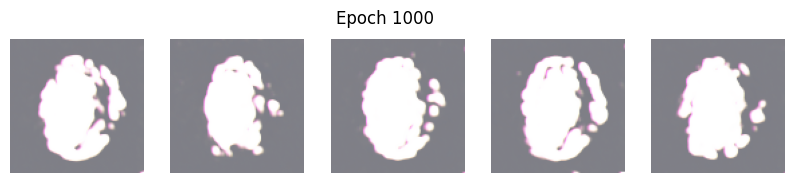

2/2 - 0s - 38ms/epoch - 19ms/step
2/2 - 0s - 29ms/epoch - 14ms/step
2/2 - 0s - 33ms/epoch - 17ms/step
2/2 - 0s - 30ms/epoch - 15ms/step
2/2 - 0s - 30ms/epoch - 15ms/step
2/2 - 0s - 31ms/epoch - 16ms/step
2/2 - 0s - 32ms/epoch - 16ms/step
2/2 - 0s - 30ms/epoch - 15ms/step
2/2 - 0s - 30ms/epoch - 15ms/step
2/2 - 0s - 32ms/epoch - 16ms/step
2/2 - 0s - 32ms/epoch - 16ms/step
2/2 - 0s - 31ms/epoch - 16ms/step
2/2 - 0s - 30ms/epoch - 15ms/step
2/2 - 0s - 33ms/epoch - 17ms/step
2/2 - 0s - 33ms/epoch - 17ms/step
2/2 - 0s - 30ms/epoch - 15ms/step
2/2 - 0s - 31ms/epoch - 16ms/step
2/2 - 0s - 30ms/epoch - 15ms/step
2/2 - 0s - 32ms/epoch - 16ms/step
2/2 - 0s - 31ms/epoch - 15ms/step
2/2 - 0s - 32ms/epoch - 16ms/step
2/2 - 0s - 33ms/epoch - 16ms/step
2/2 - 0s - 31ms/epoch - 16ms/step
2/2 - 0s - 30ms/epoch - 15ms/step
2/2 - 0s - 31ms/epoch - 16ms/step
2/2 - 0s - 30ms/epoch - 15ms/step
2/2 - 0s - 32ms/epoch - 16ms/step
2/2 - 0s - 30ms/epoch - 15ms/step
2/2 - 0s - 32ms/epoch - 16ms/step
2/2 - 0s - 31m

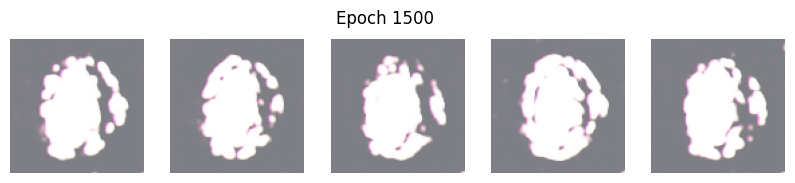

2/2 - 0s - 32ms/epoch - 16ms/step
2/2 - 0s - 31ms/epoch - 16ms/step
2/2 - 0s - 32ms/epoch - 16ms/step
2/2 - 0s - 33ms/epoch - 17ms/step
2/2 - 0s - 31ms/epoch - 16ms/step
2/2 - 0s - 35ms/epoch - 18ms/step
2/2 - 0s - 31ms/epoch - 15ms/step
2/2 - 0s - 29ms/epoch - 15ms/step
2/2 - 0s - 28ms/epoch - 14ms/step
2/2 - 0s - 32ms/epoch - 16ms/step
2/2 - 0s - 29ms/epoch - 15ms/step
2/2 - 0s - 37ms/epoch - 18ms/step
2/2 - 0s - 31ms/epoch - 15ms/step
2/2 - 0s - 30ms/epoch - 15ms/step
2/2 - 0s - 34ms/epoch - 17ms/step
2/2 - 0s - 33ms/epoch - 17ms/step
2/2 - 0s - 34ms/epoch - 17ms/step
2/2 - 0s - 31ms/epoch - 15ms/step
2/2 - 0s - 30ms/epoch - 15ms/step
2/2 - 0s - 29ms/epoch - 15ms/step
2/2 - 0s - 29ms/epoch - 14ms/step
2/2 - 0s - 31ms/epoch - 15ms/step
2/2 - 0s - 30ms/epoch - 15ms/step
2/2 - 0s - 31ms/epoch - 16ms/step
2/2 - 0s - 29ms/epoch - 14ms/step
2/2 - 0s - 30ms/epoch - 15ms/step
2/2 - 0s - 32ms/epoch - 16ms/step
2/2 - 0s - 33ms/epoch - 17ms/step
2/2 - 0s - 30ms/epoch - 15ms/step
2/2 - 0s - 30m

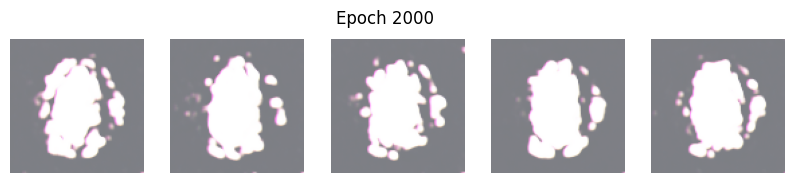

2/2 - 0s - 34ms/epoch - 17ms/step
2/2 - 0s - 30ms/epoch - 15ms/step
2/2 - 0s - 34ms/epoch - 17ms/step
2/2 - 0s - 33ms/epoch - 17ms/step
2/2 - 0s - 30ms/epoch - 15ms/step
2/2 - 0s - 35ms/epoch - 17ms/step
2/2 - 0s - 29ms/epoch - 15ms/step
2/2 - 0s - 35ms/epoch - 18ms/step
2/2 - 0s - 36ms/epoch - 18ms/step
2/2 - 0s - 39ms/epoch - 20ms/step
2/2 - 0s - 33ms/epoch - 16ms/step
2/2 - 0s - 33ms/epoch - 16ms/step
2/2 - 0s - 32ms/epoch - 16ms/step
2/2 - 0s - 29ms/epoch - 15ms/step
2/2 - 0s - 33ms/epoch - 16ms/step
2/2 - 0s - 35ms/epoch - 17ms/step
2/2 - 0s - 35ms/epoch - 17ms/step
2/2 - 0s - 29ms/epoch - 15ms/step
2/2 - 0s - 34ms/epoch - 17ms/step
2/2 - 0s - 33ms/epoch - 17ms/step
2/2 - 0s - 30ms/epoch - 15ms/step
2/2 - 0s - 28ms/epoch - 14ms/step
2/2 - 0s - 34ms/epoch - 17ms/step
2/2 - 0s - 31ms/epoch - 15ms/step
2/2 - 0s - 31ms/epoch - 16ms/step
2/2 - 0s - 32ms/epoch - 16ms/step
2/2 - 0s - 30ms/epoch - 15ms/step
2/2 - 0s - 34ms/epoch - 17ms/step
2/2 - 0s - 29ms/epoch - 15ms/step
2/2 - 0s - 31m

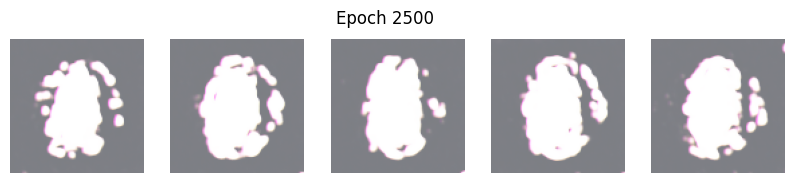

2/2 - 0s - 32ms/epoch - 16ms/step
2/2 - 0s - 30ms/epoch - 15ms/step
2/2 - 0s - 32ms/epoch - 16ms/step
2/2 - 0s - 29ms/epoch - 14ms/step
2/2 - 0s - 33ms/epoch - 16ms/step
2/2 - 0s - 32ms/epoch - 16ms/step
2/2 - 0s - 36ms/epoch - 18ms/step
2/2 - 0s - 32ms/epoch - 16ms/step
2/2 - 0s - 31ms/epoch - 16ms/step
2/2 - 0s - 28ms/epoch - 14ms/step
2/2 - 0s - 32ms/epoch - 16ms/step
2/2 - 0s - 31ms/epoch - 15ms/step
2/2 - 0s - 32ms/epoch - 16ms/step
2/2 - 0s - 32ms/epoch - 16ms/step
2/2 - 0s - 31ms/epoch - 15ms/step
2/2 - 0s - 33ms/epoch - 16ms/step
2/2 - 0s - 37ms/epoch - 19ms/step
2/2 - 0s - 36ms/epoch - 18ms/step
2/2 - 0s - 33ms/epoch - 16ms/step
2/2 - 0s - 31ms/epoch - 15ms/step
2/2 - 0s - 30ms/epoch - 15ms/step
2/2 - 0s - 33ms/epoch - 17ms/step
2/2 - 0s - 32ms/epoch - 16ms/step
2/2 - 0s - 34ms/epoch - 17ms/step
2/2 - 0s - 30ms/epoch - 15ms/step
2/2 - 0s - 30ms/epoch - 15ms/step
2/2 - 0s - 32ms/epoch - 16ms/step
2/2 - 0s - 28ms/epoch - 14ms/step
2/2 - 0s - 29ms/epoch - 14ms/step
2/2 - 0s - 39m

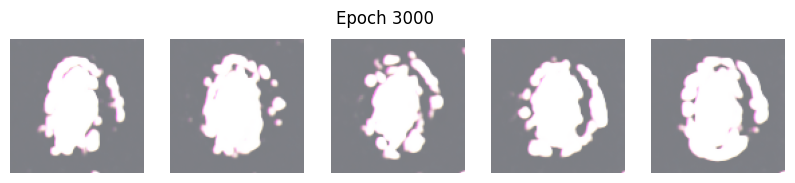

In [10]:
train_gan(image_files, generator_model, discriminator_model, gan_model, epochs=3000, batch_size=64)

#### Pada bagian modified model, saya menambahkan BatchNormalization yang umumnya digunakan untuk mempercepat konvergensi, Dropout untuk mencegah terjadinya overfitting, dan GlobalAveragePooling2D yang biasanya digunakan untuk membuat model menjadi lebih efisien dan stabil.

In [ ]:
random_input = layers.Input(shape=50)

x = layers.Dense(106 * 106 * 16, activation='relu')(random_input)
x = layers.Reshape((106, 106, 16))(x)

x = layers.Conv2D(16, kernel_size=(3, 3), strides=1, padding='valid', activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.2)(x)

x = layers.Conv2D(32, kernel_size=(3, 3), strides=1, padding='valid', activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.2)(x)

x = layers.Conv2D(64, kernel_size=(3, 3), strides=1, padding='valid', activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.2)(x)

x = layers.GlobalAveragePooling2D()(x)

output_image = layers.Dense(100 * 100 * 3, activation='tanh')(x)
output_image = layers.Reshape((100, 100, 3))(output_image)

generator_mod = models.Model(inputs=random_input, outputs=output_image)
generator_mod.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 50)]              0         
                                                                 
 dense_3 (Dense)             (None, 179776)            9168576   
                                                                 
 reshape_2 (Reshape)         (None, 106, 106, 16)      0         
                                                                 
 conv2d_11 (Conv2D)          (None, 104, 104, 16)      2320      
                                                                 
 batch_normalization_3 (Batc  (None, 104, 104, 16)     64        
 hNormalization)                                                 
                                                                 
 dropout_3 (Dropout)         (None, 104, 104, 16)      0         
                                                           

In [14]:
image_input = layers.Input(shape=(100, 100, 3))

x = layers.Conv2D(16, kernel_size=(3, 3), strides=1, padding='same', activation='relu')(image_input)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.2)(x)

x = layers.Conv2D(32, kernel_size=(3, 3), strides=2, padding='same', activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.2)(x)

x = layers.Conv2D(64, kernel_size=(3, 3), strides=2, padding='same', activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.2)(x)

x = layers.GlobalAveragePooling2D()(x)

x = layers.Flatten()(x)
output = layers.Dense(1, activation='sigmoid')(x)

discriminator_mod = models.Model(inputs=image_input, outputs=output)
discriminator_mod.summary()


Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 100, 100, 3)]     0         
                                                                 
 conv2d_14 (Conv2D)          (None, 100, 100, 16)      448       
                                                                 
 batch_normalization_6 (Batc  (None, 100, 100, 16)     64        
 hNormalization)                                                 
                                                                 
 dropout_6 (Dropout)         (None, 100, 100, 16)      0         
                                                                 
 conv2d_15 (Conv2D)          (None, 50, 50, 32)        4640      
                                                                 
 batch_normalization_7 (Batc  (None, 50, 50, 32)       128       
 hNormalization)                                           

In [15]:
generator_mod.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.01), metrics=['accuracy'])
discriminator_mod.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.01), metrics=['accuracy'])

In [ ]:
discriminator_mod.trainable=False

g_output1 = generator_mod(random_input)
d_output1 = discriminator_mod(g_output1)

gan_mod = models.Model(random_input, d_output1)
gan_mod.summary()
gan_mod.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.001))

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 50)]              0         
                                                                 
 model_3 (Functional)        (None, 100, 100, 3)       11144480  
                                                                 
 model_4 (Functional)        (None, 1)                 24097     
                                                                 
Total params: 11,168,577
Trainable params: 11,144,256
Non-trainable params: 24,321
_________________________________________________________________


2/2 - 0s - 372ms/epoch - 186ms/step
2/2 - 0s - 34ms/epoch - 17ms/step
2/2 - 0s - 34ms/epoch - 17ms/step
2/2 - 0s - 33ms/epoch - 16ms/step
2/2 - 0s - 31ms/epoch - 15ms/step
2/2 - 0s - 31ms/epoch - 16ms/step
2/2 - 0s - 33ms/epoch - 17ms/step
2/2 - 0s - 32ms/epoch - 16ms/step
2/2 - 0s - 34ms/epoch - 17ms/step
2/2 - 0s - 32ms/epoch - 16ms/step
2/2 - 0s - 32ms/epoch - 16ms/step
2/2 - 0s - 33ms/epoch - 16ms/step
2/2 - 0s - 33ms/epoch - 16ms/step
2/2 - 0s - 34ms/epoch - 17ms/step
2/2 - 0s - 31ms/epoch - 15ms/step
2/2 - 0s - 35ms/epoch - 17ms/step
2/2 - 0s - 36ms/epoch - 18ms/step
2/2 - 0s - 32ms/epoch - 16ms/step
2/2 - 0s - 31ms/epoch - 16ms/step
2/2 - 0s - 32ms/epoch - 16ms/step
2/2 - 0s - 32ms/epoch - 16ms/step
2/2 - 0s - 34ms/epoch - 17ms/step
2/2 - 0s - 33ms/epoch - 17ms/step
2/2 - 0s - 34ms/epoch - 17ms/step
2/2 - 0s - 32ms/epoch - 16ms/step
2/2 - 0s - 38ms/epoch - 19ms/step
2/2 - 0s - 34ms/epoch - 17ms/step
2/2 - 0s - 32ms/epoch - 16ms/step
2/2 - 0s - 32ms/epoch - 16ms/step
2/2 - 0s - 3

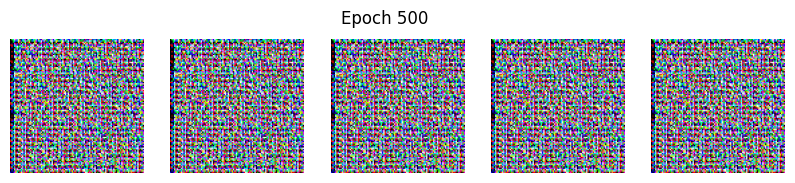

2/2 - 0s - 56ms/epoch - 28ms/step
2/2 - 0s - 31ms/epoch - 15ms/step
2/2 - 0s - 33ms/epoch - 16ms/step
2/2 - 0s - 33ms/epoch - 17ms/step
2/2 - 0s - 34ms/epoch - 17ms/step
2/2 - 0s - 33ms/epoch - 17ms/step
2/2 - 0s - 37ms/epoch - 18ms/step
2/2 - 0s - 33ms/epoch - 16ms/step
2/2 - 0s - 38ms/epoch - 19ms/step
2/2 - 0s - 38ms/epoch - 19ms/step
2/2 - 0s - 31ms/epoch - 15ms/step
2/2 - 0s - 31ms/epoch - 16ms/step
2/2 - 0s - 37ms/epoch - 19ms/step
2/2 - 0s - 32ms/epoch - 16ms/step
2/2 - 0s - 36ms/epoch - 18ms/step
2/2 - 0s - 36ms/epoch - 18ms/step
2/2 - 0s - 35ms/epoch - 18ms/step
2/2 - 0s - 42ms/epoch - 21ms/step
2/2 - 0s - 35ms/epoch - 17ms/step
2/2 - 0s - 32ms/epoch - 16ms/step
2/2 - 0s - 31ms/epoch - 15ms/step
2/2 - 0s - 32ms/epoch - 16ms/step
2/2 - 0s - 37ms/epoch - 18ms/step
2/2 - 0s - 35ms/epoch - 17ms/step
2/2 - 0s - 32ms/epoch - 16ms/step
2/2 - 0s - 32ms/epoch - 16ms/step
2/2 - 0s - 31ms/epoch - 15ms/step
2/2 - 0s - 31ms/epoch - 16ms/step
2/2 - 0s - 35ms/epoch - 17ms/step
2/2 - 0s - 35m

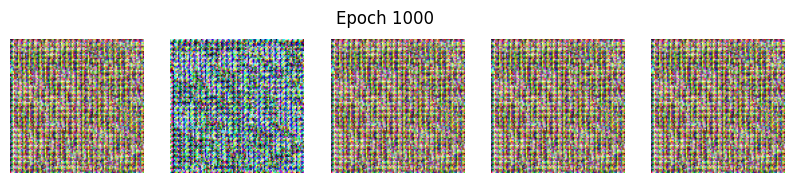

2/2 - 0s - 34ms/epoch - 17ms/step
2/2 - 0s - 35ms/epoch - 17ms/step
2/2 - 0s - 32ms/epoch - 16ms/step
2/2 - 0s - 34ms/epoch - 17ms/step
2/2 - 0s - 31ms/epoch - 15ms/step
2/2 - 0s - 32ms/epoch - 16ms/step
2/2 - 0s - 34ms/epoch - 17ms/step
2/2 - 0s - 34ms/epoch - 17ms/step
2/2 - 0s - 35ms/epoch - 17ms/step
2/2 - 0s - 34ms/epoch - 17ms/step
2/2 - 0s - 36ms/epoch - 18ms/step
2/2 - 0s - 32ms/epoch - 16ms/step
2/2 - 0s - 35ms/epoch - 17ms/step
2/2 - 0s - 30ms/epoch - 15ms/step
2/2 - 0s - 34ms/epoch - 17ms/step
2/2 - 0s - 37ms/epoch - 19ms/step
2/2 - 0s - 35ms/epoch - 17ms/step
2/2 - 0s - 34ms/epoch - 17ms/step
2/2 - 0s - 35ms/epoch - 18ms/step
2/2 - 0s - 34ms/epoch - 17ms/step
2/2 - 0s - 31ms/epoch - 16ms/step
2/2 - 0s - 36ms/epoch - 18ms/step
2/2 - 0s - 37ms/epoch - 19ms/step
2/2 - 0s - 32ms/epoch - 16ms/step
2/2 - 0s - 33ms/epoch - 16ms/step
2/2 - 0s - 37ms/epoch - 18ms/step
2/2 - 0s - 35ms/epoch - 17ms/step
2/2 - 0s - 33ms/epoch - 17ms/step
2/2 - 0s - 33ms/epoch - 16ms/step
2/2 - 0s - 34m

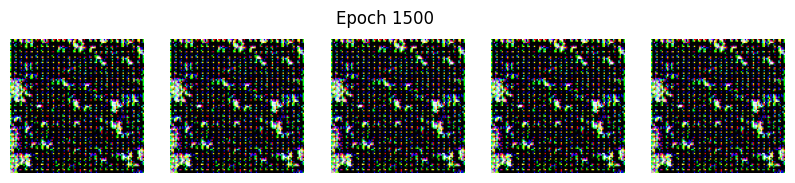

2/2 - 0s - 38ms/epoch - 19ms/step
2/2 - 0s - 33ms/epoch - 17ms/step
2/2 - 0s - 32ms/epoch - 16ms/step
2/2 - 0s - 31ms/epoch - 16ms/step
2/2 - 0s - 37ms/epoch - 18ms/step
2/2 - 0s - 34ms/epoch - 17ms/step
2/2 - 0s - 38ms/epoch - 19ms/step
2/2 - 0s - 32ms/epoch - 16ms/step
2/2 - 0s - 33ms/epoch - 17ms/step
2/2 - 0s - 32ms/epoch - 16ms/step
2/2 - 0s - 37ms/epoch - 19ms/step
2/2 - 0s - 32ms/epoch - 16ms/step
2/2 - 0s - 32ms/epoch - 16ms/step
2/2 - 0s - 32ms/epoch - 16ms/step
2/2 - 0s - 35ms/epoch - 18ms/step
2/2 - 0s - 34ms/epoch - 17ms/step
2/2 - 0s - 35ms/epoch - 18ms/step
2/2 - 0s - 32ms/epoch - 16ms/step
2/2 - 0s - 35ms/epoch - 18ms/step
2/2 - 0s - 33ms/epoch - 17ms/step
2/2 - 0s - 35ms/epoch - 17ms/step
2/2 - 0s - 35ms/epoch - 18ms/step
2/2 - 0s - 34ms/epoch - 17ms/step
2/2 - 0s - 34ms/epoch - 17ms/step
2/2 - 0s - 37ms/epoch - 19ms/step
2/2 - 0s - 35ms/epoch - 18ms/step
2/2 - 0s - 33ms/epoch - 16ms/step
2/2 - 0s - 35ms/epoch - 17ms/step
2/2 - 0s - 32ms/epoch - 16ms/step
2/2 - 0s - 37m

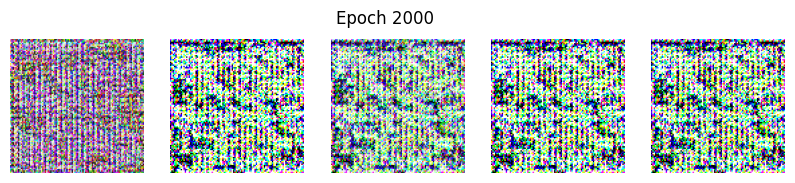

2/2 - 0s - 36ms/epoch - 18ms/step
2/2 - 0s - 34ms/epoch - 17ms/step
2/2 - 0s - 36ms/epoch - 18ms/step
2/2 - 0s - 38ms/epoch - 19ms/step
2/2 - 0s - 36ms/epoch - 18ms/step
2/2 - 0s - 31ms/epoch - 15ms/step
2/2 - 0s - 29ms/epoch - 15ms/step
2/2 - 0s - 33ms/epoch - 17ms/step
2/2 - 0s - 31ms/epoch - 16ms/step
2/2 - 0s - 32ms/epoch - 16ms/step
2/2 - 0s - 32ms/epoch - 16ms/step
2/2 - 0s - 34ms/epoch - 17ms/step
2/2 - 0s - 31ms/epoch - 16ms/step
2/2 - 0s - 32ms/epoch - 16ms/step
2/2 - 0s - 34ms/epoch - 17ms/step
2/2 - 0s - 33ms/epoch - 16ms/step
2/2 - 0s - 34ms/epoch - 17ms/step
2/2 - 0s - 34ms/epoch - 17ms/step
2/2 - 0s - 32ms/epoch - 16ms/step
2/2 - 0s - 32ms/epoch - 16ms/step
2/2 - 0s - 34ms/epoch - 17ms/step
2/2 - 0s - 36ms/epoch - 18ms/step
2/2 - 0s - 32ms/epoch - 16ms/step
2/2 - 0s - 35ms/epoch - 18ms/step
2/2 - 0s - 32ms/epoch - 16ms/step
2/2 - 0s - 33ms/epoch - 17ms/step
2/2 - 0s - 33ms/epoch - 16ms/step
2/2 - 0s - 33ms/epoch - 16ms/step
2/2 - 0s - 33ms/epoch - 16ms/step
2/2 - 0s - 31m

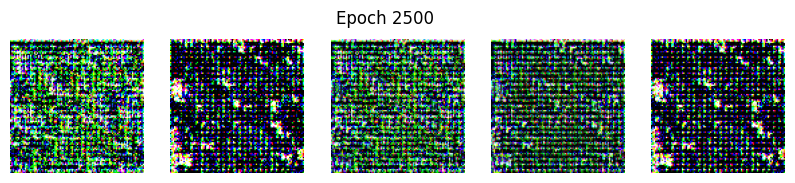

2/2 - 0s - 58ms/epoch - 29ms/step
2/2 - 0s - 40ms/epoch - 20ms/step
2/2 - 0s - 42ms/epoch - 21ms/step
2/2 - 0s - 34ms/epoch - 17ms/step
2/2 - 0s - 42ms/epoch - 21ms/step
2/2 - 0s - 33ms/epoch - 17ms/step
2/2 - 0s - 33ms/epoch - 17ms/step
2/2 - 0s - 35ms/epoch - 17ms/step
2/2 - 0s - 35ms/epoch - 18ms/step
2/2 - 0s - 36ms/epoch - 18ms/step
2/2 - 0s - 35ms/epoch - 17ms/step
2/2 - 0s - 35ms/epoch - 17ms/step
2/2 - 0s - 34ms/epoch - 17ms/step
2/2 - 0s - 32ms/epoch - 16ms/step
2/2 - 0s - 39ms/epoch - 19ms/step
2/2 - 0s - 34ms/epoch - 17ms/step
2/2 - 0s - 36ms/epoch - 18ms/step
2/2 - 0s - 33ms/epoch - 17ms/step
2/2 - 0s - 34ms/epoch - 17ms/step
2/2 - 0s - 38ms/epoch - 19ms/step
2/2 - 0s - 35ms/epoch - 18ms/step
2/2 - 0s - 35ms/epoch - 18ms/step
2/2 - 0s - 36ms/epoch - 18ms/step
2/2 - 0s - 38ms/epoch - 19ms/step
2/2 - 0s - 33ms/epoch - 16ms/step
2/2 - 0s - 39ms/epoch - 19ms/step
2/2 - 0s - 32ms/epoch - 16ms/step
2/2 - 0s - 35ms/epoch - 17ms/step
2/2 - 0s - 37ms/epoch - 19ms/step
2/2 - 0s - 35m

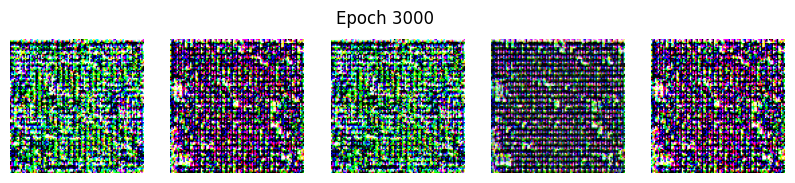

In [ ]:
train_gan(image_files, generator_mod, discriminator_mod, gan_mod, epochs=3000, batch_size=64)

#### Membuat function untuk menghitung FID.

In [ ]:
def calculate_fid(real_images, generated_images):
    real_images = real_images.astype('float32')
    generated_images = generated_images.astype('float32')

    real_images_resized = tf.image.resize(real_images, (299, 299))
    gen_images_resized = tf.image.resize(generated_images, (299, 299))

    real_images_pre = preprocess_input(real_images_resized)
    gen_images_pre = preprocess_input(gen_images_resized)

    model = InceptionV3(include_top=False, pooling='avg', input_shape=(299, 299, 3))

    act1 = model(real_images_pre)
    act2 = model(gen_images_pre)

    mu1, sigma1 = np.mean(act1, axis=0), np.cov(act1, rowvar=False)
    mu2, sigma2 = np.mean(act2, axis=0), np.cov(act2, rowvar=False)

    ssdiff = np.sum((mu1 - mu2)**2)
    covmean = sqrtm(sigma1.dot(sigma2))

    if np.iscomplexobj(covmean):
        covmean = covmean.real

    fid = ssdiff + np.trace(sigma1 + sigma2 - 2.0 * covmean)
    return fid

def get_random_noise(batch_size, noise_size):
    random_values = np.random.randn(batch_size * noise_size)
    random_noise_batch = np.reshape(random_values, (batch_size, noise_size))
    return random_noise_batch

def get_fake_samples(generator_network, batch_size, noise_size):
    random_noise_batch = get_random_noise(batch_size, noise_size)
    fake_samples = generator_network.predict_on_batch(random_noise_batch)
    return fake_samples

def get_real_samples(batch_size, image_files):
    random_indices = np.random.choice(len(image_files), size=batch_size)
    real_images = image_files[random_indices]
    return real_images

def show_generator_results(generator_network, noise_size):
    for k in range(9):
        plt.figure(figsize=(7, 7))
        fake_samples = get_fake_samples(generator_network, 9, noise_size)
        for j in range(9):
            plt.subplot(3, 3, j+1)
            img = fake_samples[j, :, :, :]
            img = 0.5 * img + 0.5
            plt.imshow(img)
            plt.axis('off')
        plt.show()

In [31]:
real_images = get_real_samples(100, image_files)
fake_images = get_fake_samples(generator_model, 100, 50)

real_images_mod = get_real_samples(100, image_files)
fake_images_mod = get_fake_samples(generator_mod, 100, 50)

print("Baseline:")
fid_score = calculate_fid(real_images, fake_images)
print("FID Score:", fid_score)
print("")
print("Modified:")
fid_score = calculate_fid(real_images_mod, fake_images_mod)
print("FID Score:", fid_score)

Baseline:
FID Score: 7.744258449356751

Modified:
FID Score: 82.53240844834187


#### Dari hasil perhitungan FID, model baseline  memiliki nilai FID 7.74, sementara model modifikasi menghasilkan nilai FID 82.53. FID digunakan untuk mengukur seberapa mirip gambar yang dihasilkan oleh model dengan gambar asli. Semakin rendah nilai FID, semakin baik kualitas gambar yang dihasilkan. Nilai FID yang lebih rendah pada model baseline menunjukkan bahwa gambar yang dihasilkan lebih mirip dengan gambar asli. Sedangkan, nilai FID yang sangat tinggi pada model modifikasi menunjukkan bahwa gambar yang dihasilkan lebih berbeda dari gambar asli, artinya kualitas gambar yang dihasilkan kurang baik. Secara keseluruhan, model baseline menghasilkan gambar yang lebih realistis dibandingkan dengan modified.